<a href="https://colab.research.google.com/github/kimgeonhee317/sd-workspace/blob/main/template/Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup


### 1. Module and libraries


In [61]:
# pip module download
!pip install diffusers==0.11.1
!pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 natsort safetensors xformers scipy

In [62]:
# import library
import torch
from diffusers import StableDiffusionPipeline

### 2. Model

In [63]:
# https://huggingface.co/stabilityai/stable-diffusion-2-1
model_id = "stabilityai/stable-diffusion-2-1"

### 3. Pipe setting

In [64]:
# pipe setting
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

text_encoder/pytorch_model.fp16.safetensors not found


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

### 4. Scheduler

In [118]:
from diffusers import DPMSolverMultistepScheduler, EulerDiscreteScheduler
#pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

### 5. Function and Variables

In [66]:
from PIL import Image

def grid_img(imgs, rows=1, cols=3, scale=1):
  assert len(imgs) == rows * cols

  w, h = imgs[0].size
  w, h = int(w*scale), int(h*scale)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      img = img.resize((w,h), Image.ANTIALIAS)
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

In [67]:
seed = 317

## Prompt

### 1. Positive
+ art : Painting, Photo, Drawing, 3D rendering, Oil painting, watercolor painting, Portrait, Sketch, Digital painting, Concept art, Ultra realistic illustration, Underwater portrait, Underwater steampunk
+ style: realistic, hyperrealistic, pop-art, modernist, art nouveau, surrealist
+ color: vivid, tones or colors, bw (black and white),vintage, gold, silver, etc.
+ artist: Van Gogh, John Collier, Monet, Alphonse Mucha, Salvador Dali, Rembrandt, Da Vinci, etc.
(https://www.urania.ai/top-sd-artists)
+ resolution: highly detailed, unreal engine (detailed and realistic 3D), sharp focus, hd, 4k or 8k, vray (3D renderizations - good results for landscapes)
+ site: artstation (art and design), pixabay, unsplash, pexels, pixiv (Japanese virtual community. It will return anime-style images)
+ others:
  + Ilumination: cinematic lighting, rim lighting, natural light, side light, sunset or golden hour
Change the vibe: dramatic, sci-fi, dystopian.

  + Add more aesthetics: stunningly beautiful, award winning photo, masterpiece.

  + Terms associated with photography (camera millimeter): 35mm, 50mm, 80mm, 85mm, wide angle, analog, fisheye lens, gopro, dslr, film, tilt-shift.

  + etc: blurred background, psychodelic, low angle shot, frontal face, expansive, detailed clothing



In [113]:
desc = "Bulbasaur in pokemon" # subject, action, location
art = ", painting"
style = ", animation"
color = ", "
#artist = ", "
resolution = ", highly detailed"
#site = ""
other = ", "

prompt = desc + art + style + resolution
prompt = "Cute small dog sitting in a movie theater eating popcorn watching a movie ,unreal engine, cozy indoor lighting, artstation, detailed, digital painting,cinematic,character design by mark ryden and pixar and hayao miyazaki, unreal 5, daz, hyperrealistic, octane render"
print(len(prompt.split(" ")))

37


### 2. Negative


In [112]:
#neg_prompt = ["bad anatomy, ugly, deformed, desfigured, distorted face, poorly drawn hands, poorly drawn face, poorly drawn feet"]
neg_prompt = "ugly, ugly arms, ugly hands"
print(len(neg_prompt.split(" ")))

5


### 3. Parameter

In [124]:
seed = 2470332296
steps = 30 # inference step (0~50)
cfg = 8.0 # how the model calculation closer to text (5~9)

width = 512
height = 512

## Implementation

In [119]:
print(pipe.scheduler)

EulerDiscreteScheduler {
  "_class_name": "EulerDiscreteScheduler",
  "_diffusers_version": "0.11.1",
  "algorithm_type": "dpmsolver++",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "dynamic_thresholding_ratio": 0.995,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "prediction_type": "v_prediction",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_type": "midpoint",
  "steps_offset": 1,
  "thresholding": false,
  "trained_betas": null
}



  0%|          | 0/30 [00:00<?, ?it/s]

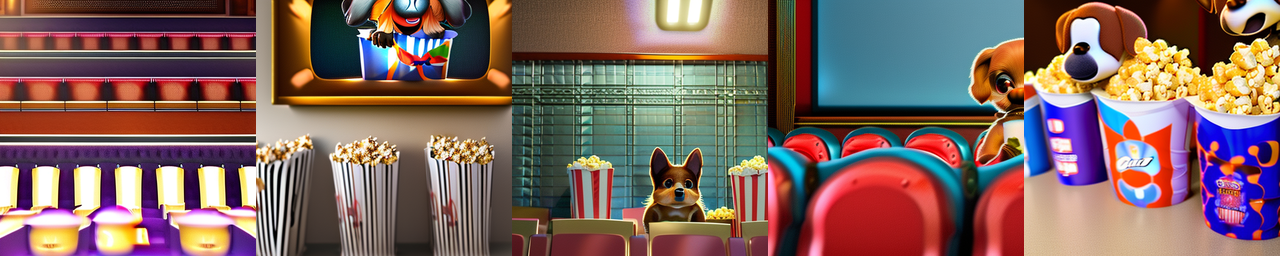

In [126]:
num_imgs = 5
imgs = pipe(prompt,
          negative_prompt=neg_prompt,
          num_images_per_prompt=num_imgs,
          generator=torch.Generator("cuda").manual_seed(seed),
          num_inference_steps=steps,
          guidance_scale = cfg,
          height = height,
          width = width).images

grid = grid_img(imgs, rows=1, cols=num_imgs, scale=0.5)
grid